In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

df = pd.read_csv('resources/transactions_2.csv')

df

,time,status,count
0,00h 00,reversed,7
1,00h 00,approved,9
2,00h 00,processing,12
3,00h 00,denied,3
4,00h 00,backend_reversed,2
...,...,...,...
3939,23h 57,denied,11
3940,23h 58,denied,4
3941,23h 58,approved,35
3942,23h 59,denied,10


In [4]:
from prophet import Prophet

df['time'] = pd.to_datetime(df['time'], format='%Hh %M')


train_status = df.loc[(df['status'] == 'reversed') | (df['status'] == 'failed')]
train = train_status.groupby([train_status['time'].dt.hour]).mean()
train = train.reset_index()

train = train[['time', 'count']].rename({'time':'ds', 'count':'y'}, axis='columns')
train['ds'] = pd.to_datetime(train['ds'], format='%H')

/tmp/ipykernel_17550/3928800973.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train = train_status.groupby([train_status['time'].dt.hour]).mean()


In [5]:
train.shape

(23, 2)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      23 non-null     datetime64[ns]
 1   y       23 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 496.0 bytes


In [7]:
m = Prophet(changepoint_range=0.95)

m.fit(train)

13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:01 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future = m.make_future_dataframe(periods=22, freq='H')
future.tail(35)

,ds
10,1900-01-01 11:00:00
11,1900-01-01 12:00:00
12,1900-01-01 13:00:00
13,1900-01-01 14:00:00
14,1900-01-01 15:00:00
15,1900-01-01 16:00:00
16,1900-01-01 17:00:00
17,1900-01-01 18:00:00
18,1900-01-01 19:00:00
19,1900-01-01 20:00:00


In [9]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
40,1900-01-02 17:00:00,3.234650,1.440573,5.148551
41,1900-01-02 18:00:00,3.268903,1.431247,5.072186
42,1900-01-02 19:00:00,3.303156,1.407850,5.035108
43,1900-01-02 20:00:00,3.337410,1.517205,5.093464
44,1900-01-02 21:00:00,3.371663,1.508032,5.294029


In [10]:
results=pd.concat([train.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

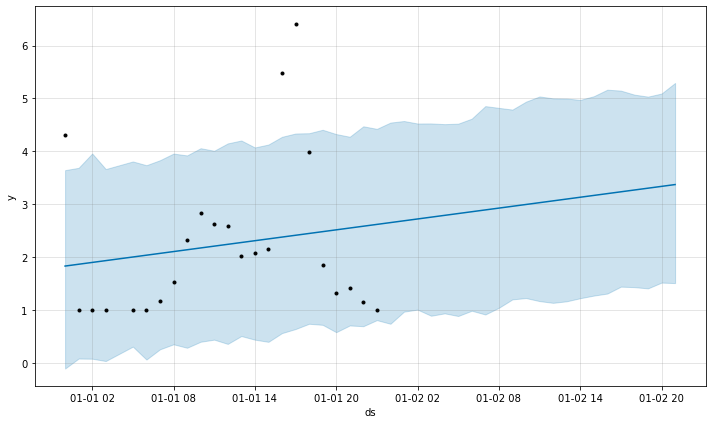

In [11]:
fig1 = m.plot(forecast)

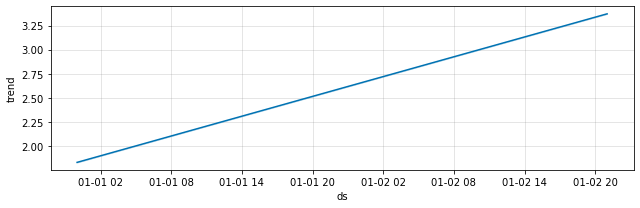

In [12]:
comp = m.plot_components(forecast)

In [13]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
1900-01-01 00:00:00,4.315789,1.830266,-0.108337,3.644332
1900-01-01 01:00:00,1.000000,1.864519,0.080822,3.688554
1900-01-01 02:00:00,1.000000,1.898772,0.077713,3.959269
1900-01-01 03:00:00,1.000000,1.933025,0.033972,3.664994
1900-01-01 05:00:00,1.000000,2.001532,0.306356,3.808878
1900-01-01 06:00:00,1.000000,2.035785,0.061752,3.737926
1900-01-01 07:00:00,1.176471,2.070039,0.255723,3.832138
1900-01-01 08:00:00,1.533333,2.104292,0.350387,3.957723
1900-01-01 09:00:00,2.326531,2.138545,0.284960,3.922944


In [14]:
results['error'] = results['y'] - results['yhat']

In [15]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [16]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
1900-01-01 00:00:00,4.315789,1.830266,-0.108337,3.644332,2.485524,3.752668
1900-01-01 01:00:00,1.000000,1.864519,0.080822,3.688554,-0.864519,3.607731
1900-01-01 02:00:00,1.000000,1.898772,0.077713,3.959269,-0.898772,3.881556
1900-01-01 03:00:00,1.000000,1.933025,0.033972,3.664994,-0.933025,3.631023
1900-01-01 05:00:00,1.000000,2.001532,0.306356,3.808878,-1.001532,3.502522
1900-01-01 06:00:00,1.000000,2.035785,0.061752,3.737926,-1.035785,3.676174
1900-01-01 07:00:00,1.176471,2.070039,0.255723,3.832138,-0.893568,3.576415
1900-01-01 08:00:00,1.533333,2.104292,0.350387,3.957723,-0.570958,3.607337
1900-01-01 09:00:00,2.326531,2.138545,0.284960,3.922944,0.187986,3.637984


In [17]:
results[results['error']].abs() > 1.5*results['uncertainty']

KeyError: "None of [Float64Index([  2.4855238550401424,  -0.8645188924097276,  -0.8987721661916925,\n                -0.933025439966469,  -1.0015319874950266,  -1.0357852612770482,\n               -0.8935679468464655,  -0.5709584755451222,  0.18798552958451475,\n                0.6703388984782452,   0.4111301879984781,   0.3512876886477918,\n              -0.25515001443555274, -0.23288837450493638, -0.19861017967641637,\n                 3.106830516040354,     4.00268296480187,   1.5431754538636109,\n               -0.6349239736028975,  -1.1897496980100624,   -1.125341942713605,\n               -1.4259429036915097,   -1.618090914111201,                  nan,\n                               nan,                  nan,                  nan,\n                               nan,                  nan,                  nan,\n                               nan,                  nan,                  nan,\n                               nan,                  nan,                  nan,\n                               nan,                  nan,                  nan,\n                               nan,                  nan,                  nan,\n                               nan,                  nan,\n                               nan],\n             dtype='float64')] are in the [columns]"